<a href="https://colab.research.google.com/github/hillspen/mthethesis/blob/main/Reverse_Channel_Coding_Simulations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from mpmath import *

mp.dps = 30; mp.pretty = True

Function Definition

In [2]:
def universal_lower_bound(alpha, renyi_divergence, *args):
  rd = renyi_divergence(2-alpha, *args)
  # print("Lower", rd)
  # return rd + np.log2(alpha) * alpha / (1-alpha) + np.log2(1/epsilon)
  # Bound with no 1/epsilon constant term
  return rd + np.log2(1/(2-alpha)) * alpha / (1-alpha)

def lt_lower_bound(alpha, renyi_divergence, *args):
  rd = renyi_divergence(1/alpha, *args)
  return rd + np.log2(alpha) * alpha / (1-alpha) - 1

def upper_bound(alpha, renyi_divergence, shannon_divergence, *args, epsilon=0.5):
  #Compute renyi divergence and Shannon divergence
  rd = renyi_divergence((2-alpha)/alpha, *args)
  # print("Upper", rd)
  sd = shannon_divergence(*args)
  # Return full upper bound
  return rd + (1+epsilon)*log(sd + 1, 2) + 3 + epsilon + log(log(2)/epsilon + 3/2, 2)

def alternate_upper_bound(alpha, renyi_divergence, *args, epsilon=0.5):
  #Compute renyi divergence
  rd = renyi_divergence((1 + epsilon*(1-alpha))/alpha, *args)
  return (1+epsilon)*rd + log(1 + 1/epsilon, 2) + 2 + epsilon

In [3]:
def bound(renyi_divergence, shannon_divergence, *args, epsilon_step=0.1):
  # *args contains relevant parameters to the renyi_divergence function signature
  lower = []
  lt_lower = []
  upper = []
  alternate_upper = []
  alphas = []
  up_epsilons = []
  upalt_epsilons = []
  for alpha in np.arange(0.501, 0.999, 0.01):
    # Upper bound calculation, only valid for 2/3 < alpha < 1
    if alpha > 2/3:
      # Set minimum value
      upper_min = inf
      # Traverse over valid epsilon range to find the minimum bound
      for epsilon in np.arange(0.001, (3*alpha - 2) / (2-2*alpha), epsilon_step):
        # Compute upper bound at that epsilon
        upper_min_candidate = upper_bound(alpha, renyi_divergence, shannon_divergence, *args, epsilon=epsilon)
        if upper_min_candidate < upper_min:
          upper_min = upper_min_candidate
          epsilon_min = epsilon
      # Append minimum upper bound found
      upper.append(upper_min)
      up_epsilons.append(epsilon_min)
    else:
      # Append inf if outside of the bound's range of validity
      upper.append(inf)
      up_epsilons.append(inf)

    # Max with 0 version
    # lower.append(max(universal_lower_bound(alpha, renyi_divergence, *args),0))
    # lt_lower.append(max(lt_lower_bound(alpha, renyi_divergence, *args), 0))

    lower.append(universal_lower_bound(alpha, renyi_divergence, *args))
    lt_lower.append(lt_lower_bound(alpha, renyi_divergence, *args))
    # Alternate upper bound that is valid for 1/2 < alpha < 1
    if alpha > 0.5:
      # Set initial minimum value
      upper_min_alt = inf
      # Traverse valid epsilon range to find minimum value
      for epsilon in np.arange(0.001, (2*alpha - 1) / (1-alpha), epsilon_step):
        # Compute upper bound at that epsilon
        upper_min_alt_candidate = alternate_upper_bound(alpha, renyi_divergence, *args, epsilon=epsilon)
        # Check if this bound is smaller than the current minimum
        if upper_min_alt_candidate < upper_min_alt:
          upper_min_alt = upper_min_alt_candidate
          epsilon_min = epsilon
      # Append lowest found bound
      alternate_upper.append(upper_min_alt)
      upalt_epsilons.append(epsilon_min)
    alphas.append(alpha)
  return lower, lt_lower, upper, alternate_upper, alphas, up_epsilons, upalt_epsilons

Example: Bernoulli distributions

In [4]:
# Renyi and Shannon divergence between two Bernoulli distributions
# Compute renyi divergence between P, Q
def renyi_divergence_b(alpha, p, q):
  return 1/(alpha - 1)*log((power(p, alpha)*power(q, 1-alpha) + power(1-p, alpha)*power(1-q, 1-alpha)), 2)

def shannon_divergence_b(p, q):
  return p*log(p / q, 2) + (1-p)*log((1-p) / (1-q), 2)

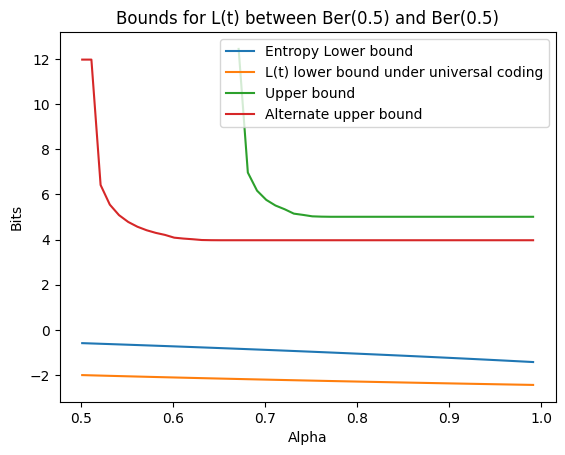

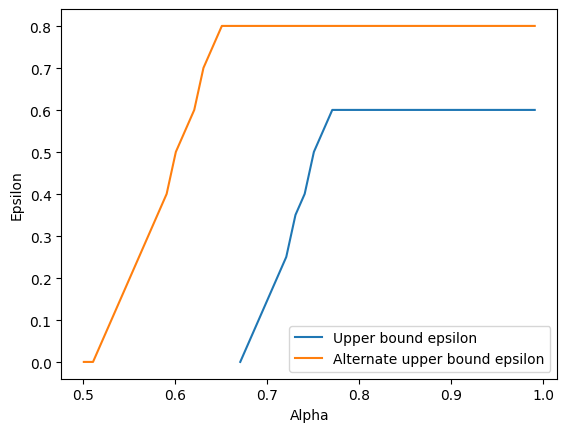

In [5]:
# Variables
p = 0.5
q = 0.5

# Create array of bounds
lower, lt_lower, upper, alternate_upper, alphas, up_epsilons, upalt_epsilons = bound(renyi_divergence_b, shannon_divergence_b, p, q, epsilon_step=0.05)

# Plot
plt.plot(alphas, lower, label='Entropy Lower bound')
plt.plot(alphas, lt_lower, label='L(t) lower bound under universal coding')
plt.plot(alphas, upper, label='Upper bound')
plt.plot(alphas, alternate_upper, label='Alternate upper bound')
plt.title(f'Bounds for L(t) between Ber({p}) and Ber({q})')
plt.xlabel('Alpha')
plt.ylabel('Bits')
plt.legend()
plt.show()


plt.plot(alphas, up_epsilons, label='Upper bound epsilon')
plt.plot(alphas, upalt_epsilons, label='Alternate upper bound epsilon')
plt.legend()
plt.xlabel('Alpha')
plt.ylabel('Epsilon')
plt.show()

Example: Gaussian distributions

In [6]:
def renyi_divergence_g(alpha, mui, sigmai, muj, sigmaj):
  sigmastar = alpha*pow(sigmaj, 2) + (1-alpha)*pow(sigmai, 2)

  return log(sigmaj / sigmai, 2) + 1/(2*(alpha - 1))*log(pow(sigmaj, 2) / sigmastar, 2) + 1/2*(alpha*pow(mui - muj, 2)) / sigmastar

def shannon_divergence_g(mui, sigmai, muj, sigmaj):
  return log(sigmaj / sigmai, 2) + (pow(sigmai, 2) + pow(mui - muj, 2)) / (2*pow(sigmaj, 2)) - 1/2

In [7]:
def plot_bounds_g(mu1, sigma1, mu2, sigma2, epsilon_step=0.1):
  # plt.rcParams['text.usetex'] = True
  lower, lt_lower, upper, alternate_upper, alphas, up_epsilons, upalt_epsilons = bound(renyi_divergence_g, shannon_divergence_g, mu1, sigma1, mu2, sigma2, epsilon_step=epsilon_step)
  plt.plot(alphas, upper, label='Theorem 1 upper bound')
  plt.plot(alphas, alternate_upper, label='Theorem 2 upper bound')
  plt.plot(alphas, lower, label='Theorem 3 lower bound')
  plt.plot(alphas, lt_lower, label='Theorem 4 L(t) lower bound')
  plt.xlabel(r'$\alpha$')
  plt.ylabel('Boudns (bits)')
  plt.legend()
  plt.savefig(f'bounds{mu1, mu2}.png')
  plt.show()


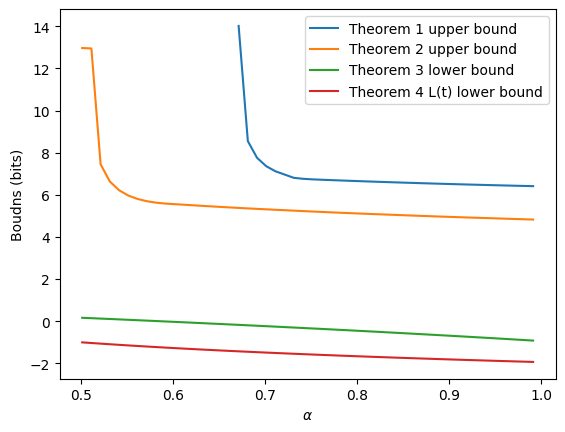

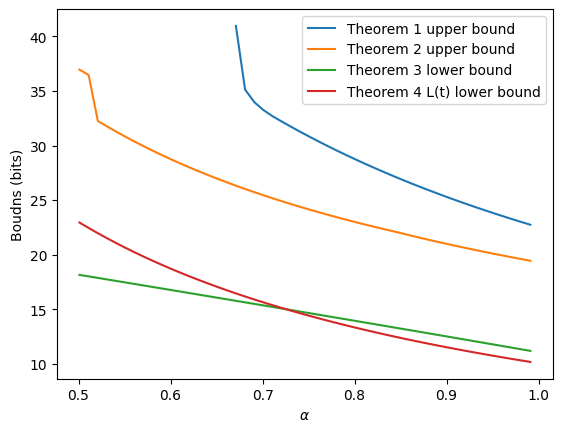

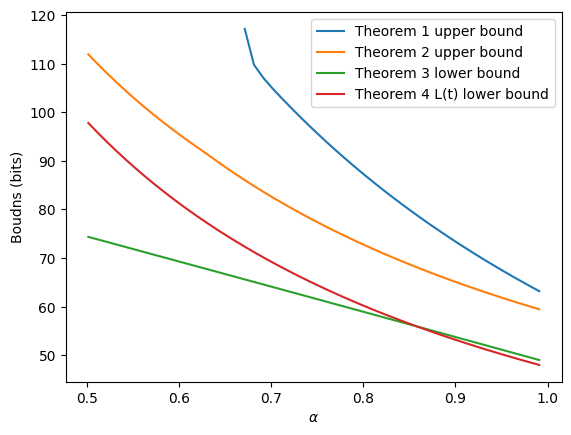

In [8]:
# Variables
mu1 = 0
sigma1 = 1
mu2 = 10
sigma2 = 1

plot_bounds_g(0, 1, 1, 1, epsilon_step=0.05)
plot_bounds_g(0, 1, 5, 1, epsilon_step=0.05)
plot_bounds_g(mu1, sigma1, mu2, sigma2, epsilon_step=0.05)

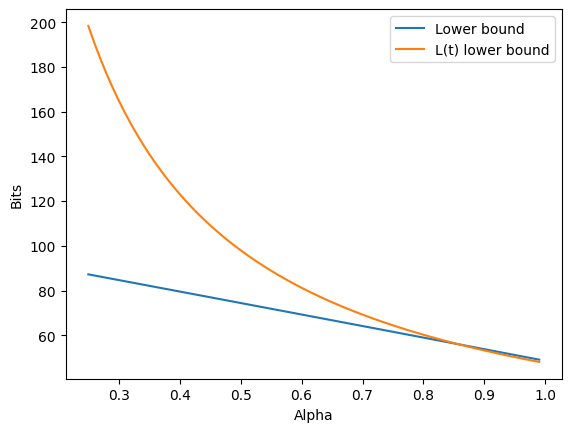

In [9]:
lower = []
lt_lower = []

start = 0.25
end = 0.999

for alpha in np.arange(start, end, 0.01):
  lower.append(universal_lower_bound(alpha, renyi_divergence_g, mu1, sigma1, mu2, sigma2))
  lt_lower.append(lt_lower_bound(alpha, renyi_divergence_g, mu1, sigma1, mu2, sigma2))

plt.plot(np.arange(start, end, 0.01), lower, label='Lower bound')
plt.plot(np.arange(start, end, 0.01), lt_lower, label='L(t) lower bound')
plt.xlabel('Alpha')
plt.ylabel('Bits')
plt.legend()
plt.show()

Example: Renyi divergence

In [10]:
def renyi_divergence_e(alpha, lambda1, lambda2):
  return log(lambda1 / lambda2) + 1/(alpha-1)*log(lambda1 / (alpha*lambda1 + (1-alpha)*lambda2))

def shannon_divergence_e(lambda1, lambda2):
  return log(lambda1 / lambda2) + (lambda2 - lambda1)/lambda1

In [11]:
# Variables
lambda1 = 150900
lambda2 = 1

lower, upper, alternate_upper, alphas, up_epsilons, upalt_epsilons = bound(renyi_divergence_e, shannon_divergence_e, lambda1, lambda2, epsilon_step=0.05)

# Plot
plt.plot(alphas, lower, label='Lower bound')
plt.plot(alphas, upper, label='Upper bound')
plt.plot(alphas, alternate_upper, label='Alternate upper bound')
plt.title(f'Bounds for L(t) between Exp({lambda1}) and Exp({lambda2})')
plt.xlabel('Alpha')
plt.ylabel('Bits')
plt.legend()
plt.show()

plt.plot(alphas, up_epsilons, label='Upper bound')
plt.plot(alphas, upalt_epsilons, label='Alternate upper bound')
plt.xlabel('Alpha')
plt.ylabel('Epsilon')
plt.legend()
plt.show()

ValueError: too many values to unpack (expected 6)

Upper Bound and Alternate Upper Bound Comparison

In [ ]:
# Plotting the different orders of the Renyi divergence
const = 0.5
alphas = np.array(arange(0.5, 1, 0.01))
plt.plot(alphas, (2-alphas)/alphas, label='Upper bound')
plt.plot(alphas, (1 + const*(1-alphas))/alphas, label='Alternate upper bound')
plt.title(f'Order of Rényi divergence for upper and alternate upper bound, epsilon={const}')
plt.xlabel('Alpha')
plt.ylabel('Order of Rényi Divergence')
plt.legend()
plt.show()

# Plotting the different values of the renyi divergence
epsilon = 0.5
mu1 = 1
sigma1 = 1
mu2 = 5
sigma2 = 1.5
alphas = np.array(arange(0.5, 0.99, 0.01))
upper_bounds = []
upper_bound_alt = []
for alpha in alphas:
  upper_bounds.append(renyi_divergence_g((2-alpha)/alpha, mu1, sigma1, mu2, sigma2))
  upper_bound_alt.append(renyi_divergence_g((1 + epsilon*(1-alpha))/alpha, mu1, sigma1, mu2, sigma2))

plt.plot(alphas, upper_bounds, label='Upper bound Rényi divergence term')
plt.plot(alphas, upper_bound_alt, label='Alternate upper bound Rényi divergence term')
plt.title(f'Rényi divergence terms between N({mu1}, {sigma1}) and N({mu2}, {sigma2})')
plt.xlabel('Alpha')
plt.ylabel('Rényi divergence')
plt.legend()
plt.show()

# Plotting the different constant terms against epsilon
up = []
up_alt = []
epsilons = []
for epsilon in np.arange(0.01, 2, 0.01):
  up.append((1+epsilon)*log(np.e, 2) + log(log(2)/epsilon + 3/2, 2))
  up_alt.append(log(1 + 1/epsilon, 2) + 1 + epsilon)
  epsilons.append(epsilon)

plt.plot(epsilons, up, label='Upper bound')
plt.plot(epsilons, up_alt, label='Alternate upper bound')
plt.legend()
plt.xlabel('Epsilon')
plt.ylabel('Bits')
plt.title('Constant term value as epsilon varies')
plt.show()

In [ ]:
alpha = 0.75
epsilon = 0.75
lambda1 = 3
lambda2 = 3

print(renyi_divergence_e((2-alpha)/alpha, lambda1, lambda2))
print(renyi_divergence_e((1 + epsilon*(1-alpha))/alpha, lambda1, lambda2))